<a href="https://colab.research.google.com/github/Nishorgo26/Project_2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title ✅ Setup: GPU, deps, optional Drive
import sys, os, torch
print("Python:", sys.version)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Quiet installs
!pip -q install torchvision torchaudio scikit-learn matplotlib

# Optional: save to Drive
USE_DRIVE = False  #@param {type:"boolean"}
ARTIFACT_DIR = "/content/drive/MyDrive/vgg19_cifar10_prune_artifacts" if USE_DRIVE else "/content/artifacts"
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts →", ARTIFACT_DIR)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Artifacts → /content/artifacts


In [ ]:
#@title 🔧 Imports, seeds, metrics, dataloaders, plotting (fixed)
import time, copy, random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from torch.nn.utils import prune

# Repro (keep cudnn fast)
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

CIFAR10_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def build_dataloaders(data_root, batch_size, num_workers=2, val_ratio=0.1):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2470, 0.2435, 0.2616])
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), normalize])

    train_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
    test_set   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

    n_val = int(len(train_full) * val_ratio)
    n_train = len(train_full) - n_val
    train_set, val_set = random_split(train_full, [n_train, n_val],
                                      generator=torch.Generator().manual_seed(123))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

# === Plotting (matplotlib; no seaborn, no custom colors) ===
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

def plot_curves(history, outdir):
    # Loss
    plt.figure()
    plt.plot(history["epoch"], history["train_loss"], label="train_loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Loss")
    plt.tight_layout(); plt.savefig(Path(outdir)/"loss_curves.png"); plt.close()
    # Accuracy
    plt.figure()
    plt.plot(history["epoch"], history["train_acc"], label="train_acc")
    plt.plot(history["epoch"], history["val_acc"],   label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Accuracy")
    plt.tight_layout(); plt.savefig(Path(outdir)/"acc_curves.png"); plt.close()

def plot_confusion(cm, classes, outpath, normalize=False, title="Confusion Matrix"):
    # FIX: dynamic formatting; ints for raw CM, .2f for normalized
    cm = np.array(cm)
    if normalize:
        cm = cm.astype(np.float64)
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
        fmt = ".2f"
    else:
        if cm.dtype.kind == 'f':
            cm = np.rint(cm).astype(np.int64)
        fmt = "d"

    plt.figure(figsize=(6.5, 5.5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    Path(outpath).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(outpath); plt.close()

def plot_per_class_bars(report_dict, outstem):
    y_true, y_pred = report_dict.get("y_true"), report_dict.get("y_pred")
    if y_true is None or y_pred is None: return
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(10)), zero_division=0)
    x = np.arange(len(CIFAR10_CLASSES))
    # Precision
    plt.figure(); plt.bar(x, p); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
    plt.ylabel("Precision"); plt.title("Per-class Precision"); plt.tight_layout()
    plt.savefig(f"{outstem}_precision.png"); plt.close()
    # Recall
    plt.figure(); plt.bar(x, r); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
    plt.ylabel("Recall"); plt.title("Per-class Recall"); plt.tight_layout()
    plt.savefig(f"{outstem}_recall.png"); plt.close()
    # F1
    plt.figure(); plt.bar(x, f1); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
    plt.ylabel("F1-score"); plt.title("Per-class F1-score"); plt.tight_layout()
    plt.savefig(f"{outstem}_f1.png"); plt.close()


In [ ]:
#@title 🧠 Model (VGG19), train/eval, structured pruning, sparsity
def build_vgg19(num_classes=10, pretrained=False):
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT if pretrained else None)
    in_features = model.classifier[-1].in_features
    head = list(model.classifier.children())
    head[-1] = nn.Linear(in_features, num_classes)
    model.classifier = nn.Sequential(*head)
    return model

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                logits = model(x); loss = criterion(logits, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            logits = model(x); loss = criterion(logits, y)
            loss.backward(); optimizer.step()
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, device, return_preds=False):
    model.eval()
    y_true, y_pred = [], []
    total, running_loss = 0, 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x); loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        y_true.append(y.cpu().numpy()); y_pred.append(pred.cpu().numpy())
        total += y.size(0)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    p_mic, r_mic, f1_mic, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    return {
        "loss": running_loss / total,
        "accuracy": acc,
        "precision_macro": p_mac, "recall_macro": r_mac, "f1_macro": f1_mac,
        "precision_micro": p_mic, "recall_micro": r_mic, "f1_micro": f1_mic,
        "confusion_matrix": cm,
        "y_true": y_true if return_preds else None,
        "y_pred": y_pred if return_preds else None,
        "class_report": classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES, zero_division=0)
    }

def prune_for_inference(model, amount=0.3, structured=True, progressive=True):
    """
    Structured pruning by default.
      - Conv2d: prune output channels (dim=0) by L2 norm
      - Linear: prune output units (dim=0)
    progressive=True → slightly more pruning in deeper layers.
    Note: shapes are not physically shrunk; channels are zeroed (structured sparsity).
    """
    m = copy.deepcopy(model)
    # collect target layers
    targets = [mod for mod in m.modules() if isinstance(mod, (nn.Conv2d, nn.Linear))]
    if not targets:
        return m

    if structured:
        if progressive and len(targets) > 1:
            import torch as _torch
            scales = _torch.linspace(0.8, 1.2, steps=len(targets)).tolist()
            per_layer = [max(0.0, min(0.95, s * amount)) for s in scales]
        else:
            per_layer = [max(0.0, min(0.95, amount))] * len(targets)

        for mod, amt in zip(targets, per_layer):
            if isinstance(mod, nn.Conv2d):
                prune.ln_structured(mod, name="weight", amount=amt, n=2, dim=0)  # drop output channels
                prune.remove(mod, "weight")
            elif isinstance(mod, nn.Linear):
                prune.ln_structured(mod, name="weight", amount=amt, n=2, dim=0)  # drop output units
                prune.remove(mod, "weight")
    else:
        for mod in targets:
            prune.l1_unstructured(mod, name="weight", amount=amount)
            prune.remove(mod, "weight")
    return m

@torch.no_grad()
def report_sparsity(model):
    zeros_total, params_total = 0, 0
    details = []
    for name, p in model.named_parameters():
        if p is None or p.numel() == 0:
            continue
        num = p.numel()
        z = (p == 0).sum().item()
        frac = z / num
        zeros_total += z; params_total += num
        details.append((name, z, num, frac))
    global_frac = zeros_total / params_total if params_total > 0 else 0.0
    return global_frac, details


Device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


VGG19 params: total=139.61M, trainable=139.61M

=== TRAINING ===


/tmp/ipython-input-82138220.py:324: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Epoch 01/40 | tr_loss 2.2787 tr_acc 0.1215 | val_loss 2.2052 val_acc 0.1622 | val_f1(macro) 0.0914 | 52.8s
Epoch 02/40 | tr_loss 2.1188 tr_acc 0.1894 | val_loss 2.0759 val_acc 0.1966 | val_f1(macro) 0.1207 | 20.1s
Epoch 03/40 | tr_loss 1.9759 tr_acc 0.2368 | val_loss 1.8775 val_acc 0.2734 | val_f1(macro) 0.2322 | 20.1s
Epoch 04/40 | tr_loss 1.8365 tr_acc 0.3022 | val_loss 1.7777 val_acc 0.3400 | val_f1(macro) 0.3224 | 19.9s
Epoch 05/40 | tr_loss 1.7116 tr_acc 0.3591 | val_loss 1.5866 val_acc 0.4146 | val_f1(macro) 0.3974 | 20.1s
Epoch 06/40 | tr_loss 1.5629 tr_acc 0.4258 | val_loss 1.4967 val_acc 0.4678 | val_f1(macro) 0.4672 | 20.3s
Epoch 07/40 | tr_loss 1.4243 tr_acc 0.4813 | val_loss 1.3158 val_acc 0.5280 | val_f1(macro) 0.5183 | 19.9s
Epoch 08/40 | tr_loss 1.2945 tr_acc 0.5312 | val_loss 1.3317 val_acc 0.5118 | val_f1(macro) 0.4984 | 20.3s
Epoch 09/40 | tr_loss 1.2170 tr_acc 0.5627 | val_loss 1.1857 val_acc 0.5794 | val_f1(macro) 0.5710 | 20.1s
Epoch 10/40 | tr_loss 1.1524 tr_acc 0

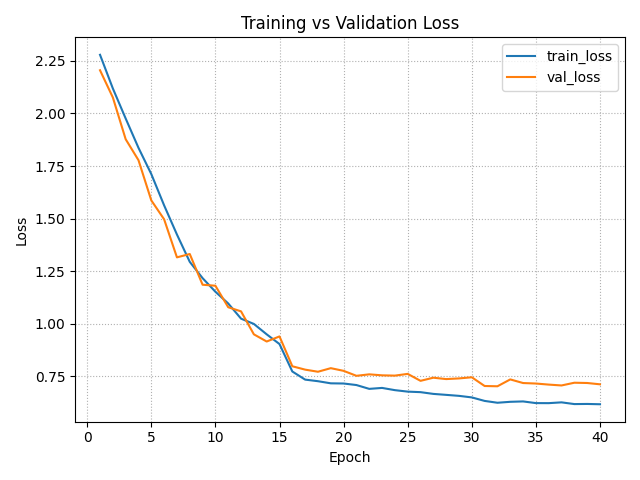

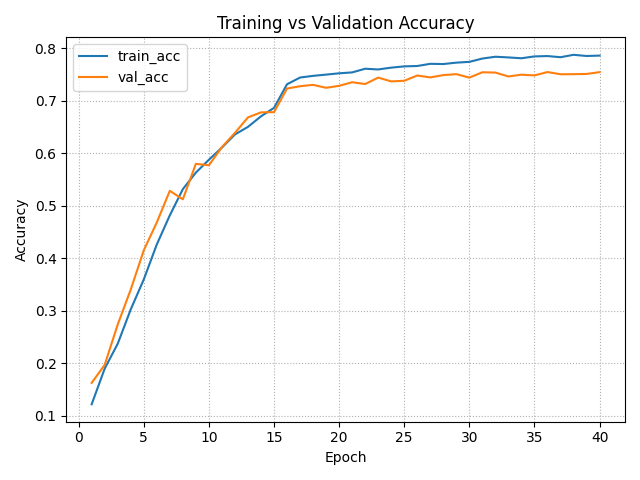

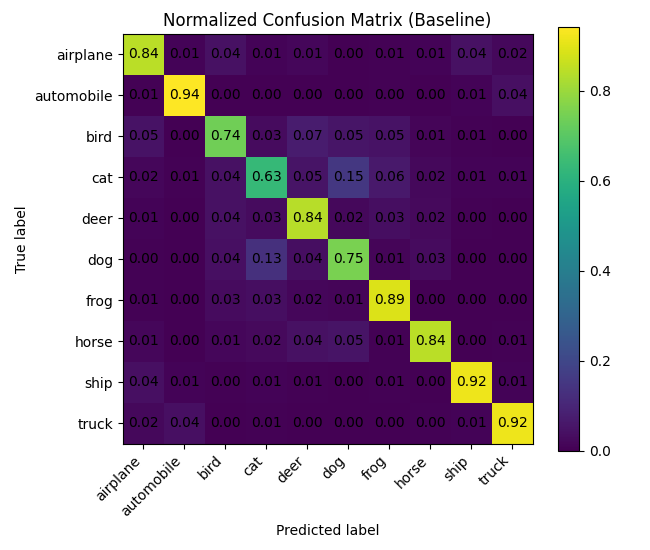


=== APPLY PRUNING (inference) | structured=True, amount=0.3 ===
Global weight sparsity after pruning: 30.01%

=== TEST: Pruned ===
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       1.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.15      0.97      0.26      1000
         dog       0.00      0.00      0.00      1000
        frog       0.25      0.83      0.38      1000
       horse       0.00      0.00      0.00      1000
        ship       1.00      0.01      0.02      1000
       truck       1.00      0.03      0.07      1000

    accuracy                           0.18     10000
   macro avg       0.34      0.18      0.07     10000
weighted avg       0.34      0.18      0.07     10000

Pruned  Acc: 0.1843 | F1(macro): 0.0721


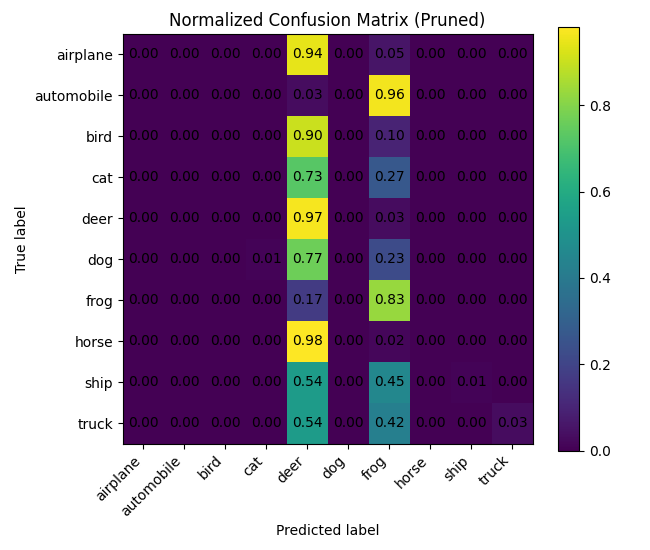


=== FINE-TUNE (pruned model) ===
FT 01/5 | tr_loss 1.3746 tr_acc 0.5489 | val_loss 1.0147 val_acc 0.6484 | val_f1(macro) 0.6236
FT 02/5 | tr_loss 0.9284 tr_acc 0.6764 | val_loss 0.8912 val_acc 0.6896 | val_f1(macro) 0.6821
FT 03/5 | tr_loss 0.8425 tr_acc 0.7107 | val_loss 0.8669 val_acc 0.7004 | val_f1(macro) 0.6947
FT 04/5 | tr_loss 0.8166 tr_acc 0.7167 | val_loss 0.8441 val_acc 0.7160 | val_f1(macro) 0.7152
FT 05/5 | tr_loss 0.7922 tr_acc 0.7265 | val_loss 0.8316 val_acc 0.7134 | val_f1(macro) 0.7114

=== TEST: Pruned + Fine-Tuned ===
              precision    recall  f1-score   support

    airplane       0.81      0.80      0.80      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.71      0.65      0.68      1000
         cat       0.69      0.45      0.55      1000
        deer       0.75      0.80      0.77      1000
         dog       0.64      0.75      0.69      1000
        frog       0.76      0.91      0.83      1000
       horse       0.83

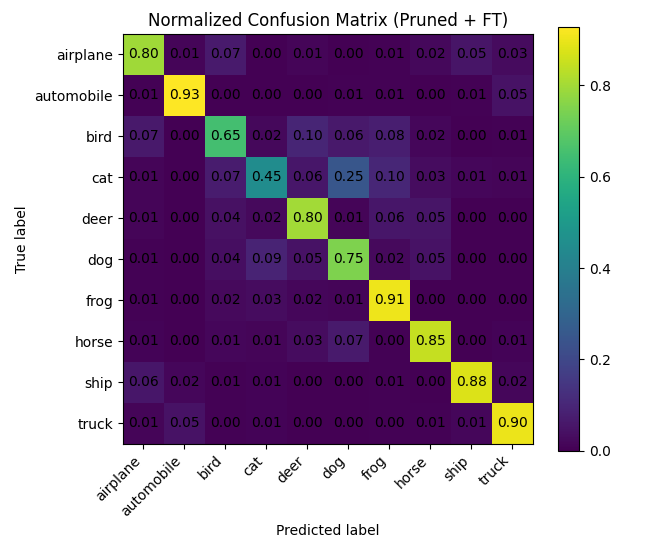


=== COMPARISON (test) ===
Model     | Acc    | Prec(mac) | Rec(mac) | F1(mac)
----------+--------+-----------+----------+--------
Baseline  | 0.8314 | 0.8308    | 0.8314   | 0.8306 
Pruned    | 0.1843 | 0.3394    | 0.1843   | 0.0721 
Pruned+FT | 0.7907 | 0.7898    | 0.7907   | 0.7864 

=== HARDWARE METRICS ===
Hardware: {'python': '3.12.11', 'pytorch': '2.8.0+cu126', 'cuda_available': True, 'device': 'cuda', 'gpu_name': 'NVIDIA A100-SXM4-80GB', 'capability': (8, 0), 'cuda_version': '12.6'}
Baseline   | bs=  1 |    2.72 ms |    367.8 img/s
Baseline   | bs= 16 |    2.71 ms |   5902.9 img/s
Baseline   | bs= 64 |    2.80 ms |  22838.7 img/s
Baseline   | bs=128 |    2.99 ms |  42845.5 img/s
Pruned     | bs=  1 |    2.74 ms |    364.7 img/s
Pruned     | bs= 16 |    2.68 ms |   5973.6 img/s
Pruned     | bs= 64 |    2.82 ms |  22705.5 img/s
Pruned     | bs=128 |    2.94 ms |  43514.7 img/s
Pruned+FT  | bs=  1 |    2.76 ms |    362.5 img/s
Pruned+FT  | bs= 16 |    2.63 ms |   6076.2 img/s
Prun

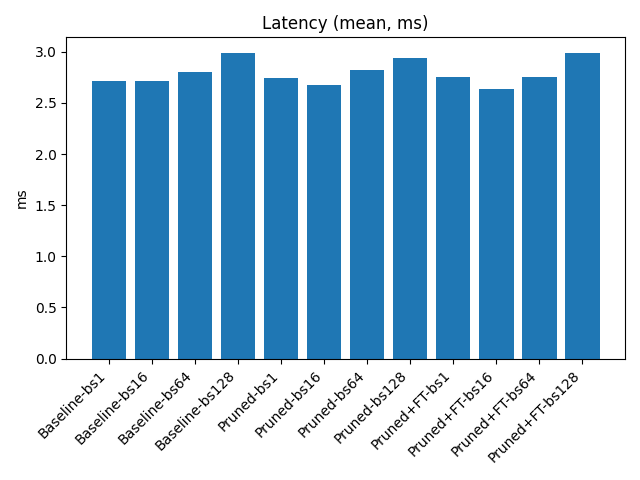

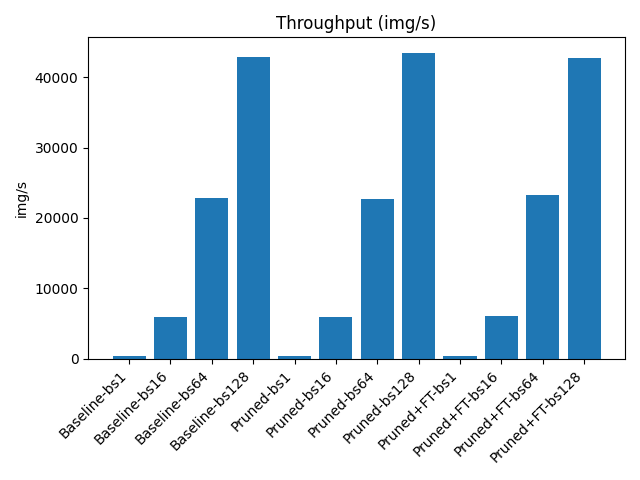


=== SUMMARY: Metrics ===
Baseline : Acc 0.8314 | F1 0.8306
Pruned   : Acc 0.1843 | F1 0.0721  (ΔAcc -0.6471, ΔF1 -0.7584)
Pruned+FT: Acc 0.7907 | F1 0.7864  (vs Base ΔAcc -0.0407, ΔF1 -0.0441)

=== SUMMARY: Compute (GMACs@bs1 / MParams) ===
Baseline : 0.518 GMACs / 139.61 MParams
Pruned   : 0.518 GMACs / 139.61 MParams
Pruned+FT: 0.518 GMACs / 139.61 MParams

=== SUMMARY: Latency/Throughput @ bs=128 on CUDA ===
Baseline : 2.99 ms | 42845.5 img/s
Pruned   : 2.94 ms | 43514.7 (Δlat -0.05 ms, Δthr +669.2)
Pruned+FT: 2.99 ms | 42772.8 (vs Base Δlat +0.01, Δthr -72.7)

=== EXPLANATION (why) ===
- Accuracy/F1 dropped after pruning: capacity reduced; short fine-tuning and/or a lower PRUNE_AMOUNT typically recovers performance.
- Fine-tuning recovered pruned performance, which is common at higher prune ratios or with structured pruning.
- Structured pruning zeros whole channels/units. PyTorch keeps tensor shapes; for big latency gains, add channel packing or export to an engine that removes d

In [1]:
#@title 🚀 VGG19 on CIFAR-10: Train → Prune → Evaluate → Hardware Metrics (Latency/Throughput) + Plots + Verdict

# ===========================
# Knobs
# ===========================
SEED = 42                 #@param {type:"integer"}
EPOCHS = 40               #@param {type:"integer"}
BATCH  = 256              #@param {type:"integer"}
LR     = 0.01             #@param {type:"number"}
MOMENTUM = 0.9            #@param {type:"number"}
WEIGHT_DECAY = 5e-4       #@param {type:"number"}
STEP_SIZE = 15            #@param {type:"integer"}
GAMMA     = 0.1           #@param {type:"number"}

# Pruning behavior
STRUCTURED   = True       # True = channel/unit pruning (L2, dim=0); False = unstructured L1
PRUNE_AMOUNT = 0.30       # 0.2–0.5 typical; >0.3 usually needs FT

# Plotting & Fine-tuning
PLOT = True               # save & show plots
DO_FT = True              # fine-tune pruned model to recover accuracy
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LR     = 5e-4

# Hardware benchmarking
BENCH_BATCH_SIZES = [1, 16, 64, 128]   # adjust for VRAM
BENCH_ITERS       = 120
BENCH_WARMUP      = 20

ARTIFACT_DIR = "/content/artifacts"

# ===========================
# Imports & Setup
# ===========================
import sys, os, time, copy, random, platform, json
import numpy as np
from pathlib import Path
from statistics import mean, median

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from torch.nn.utils import prune

# quiet install for thop (FLOPs/MACs)
!pip -q install thop
from thop import profile

# plotting
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from IPython.display import Image, display

# ensure artifacts dir
outdir = Path(ARTIFACT_DIR); outdir.mkdir(parents=True, exist_ok=True)

# ===========================
# Utils: seeds, data, model
# ===========================
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

CIFAR10_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def build_dataloaders(data_root, batch_size, num_workers=2, val_ratio=0.1):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2470, 0.2435, 0.2616])
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), normalize])

    train_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
    test_set   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

    n_val = int(len(train_full) * val_ratio)
    n_train = len(train_full) - n_val
    train_set, val_set = random_split(train_full, [n_train, n_val],
                                      generator=torch.Generator().manual_seed(123))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

def build_vgg19(num_classes=10, pretrained=False):
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT if pretrained else None)
    in_features = model.classifier[-1].in_features
    head = list(model.classifier.children())
    head[-1] = nn.Linear(in_features, num_classes)
    model.classifier = nn.Sequential(*head)
    return model

# ===========================
# Train / Eval
# ===========================
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                logits = model(x); loss = criterion(logits, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            logits = model(x); loss = criterion(logits, y)
            loss.backward(); optimizer.step()
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, device, return_preds=False):
    model.eval()
    y_true, y_pred = [], []
    total, running_loss = 0, 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        y_true.append(y.cpu().numpy()); y_pred.append(pred.cpu().numpy())
        total += y.size(0)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    p_mic, r_mic, f1_mic, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    return {
        "loss": running_loss / total,
        "accuracy": acc,
        "precision_macro": p_mac, "recall_macro": r_mac, "f1_macro": f1_mac,
        "precision_micro": p_mic, "recall_micro": r_mic, "f1_micro": f1_mic,
        "confusion_matrix": cm,
        "y_true": y_true if return_preds else None,
        "y_pred": y_pred if return_preds else None,
        "class_report": classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES, zero_division=0)
    }

# ===========================
# Pruning (per your spec)
# ===========================
def prune_for_inference(model, amount=0.3, structured=True):
    """
    structured=True  → drop entire output channels/units (L2, dim=0) via ln_structured
    structured=False → zero individual weights (L1) via l1_unstructured
    In both modes, prune.remove(...) makes sparsity permanent (removes reparam hooks).
    """
    m = copy.deepcopy(model)
    for mod in m.modules():
        if isinstance(mod, (nn.Conv2d, nn.Linear)):
            if structured:
                prune.ln_structured(mod, name="weight", amount=amount, n=2, dim=0)
                prune.remove(mod, "weight")
            else:
                prune.l1_unstructured(mod, name="weight", amount=amount)
                prune.remove(mod, "weight")
    return m

@torch.no_grad()
def report_sparsity(model):
    zeros_total, params_total = 0, 0
    for _, p in model.named_parameters():
        if p is None or p.numel() == 0:
            continue
        params_total += p.numel()
        zeros_total  += (p == 0).sum().item()
    return zeros_total / params_total if params_total > 0 else 0.0

# ===========================
# Plots (confusion fix included)
# ===========================
def plot_curves(history, outdir):
    # Loss
    plt.figure()
    plt.plot(history["epoch"], history["train_loss"], label="train_loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Loss")
    plt.tight_layout(); plt.savefig(Path(outdir)/"loss_curves.png"); plt.close()
    # Accuracy
    plt.figure()
    plt.plot(history["epoch"], history["train_acc"], label="train_acc")
    plt.plot(history["epoch"], history["val_acc"],   label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Accuracy")
    plt.tight_layout(); plt.savefig(Path(outdir)/"acc_curves.png"); plt.close()

def plot_confusion(cm, classes, outpath, normalize=False, title="Confusion Matrix"):
    cm = np.array(cm)
    if normalize:
        cm = cm.astype(np.float64)
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
        fmt = ".2f"
    else:
        if cm.dtype.kind == 'f':
            cm = np.rint(cm).astype(np.int64)
        fmt = "d"
    plt.figure(figsize=(6.5, 5.5)); plt.imshow(cm, interpolation='nearest'); plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes)); plt.xticks(ticks, classes, rotation=45, ha="right"); plt.yticks(ticks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    Path(outpath).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(outpath); plt.close()

def plot_per_class_bars(report_dict, outstem):
    y_true, y_pred = report_dict.get("y_true"), report_dict.get("y_pred")
    if y_true is None or y_pred is None: return
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(10)), zero_division=0)
    x = np.arange(len(CIFAR10_CLASSES))
    for name, vals in [("precision", p), ("recall", r), ("f1", f1)]:
        plt.figure(); plt.bar(x, vals); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
        plt.ylabel(name.capitalize()); plt.title(f"Per-class {name.capitalize()}"); plt.tight_layout()
        plt.savefig(f"{outstem}_{name}.png"); plt.close()

def plot_bar(x, y, title, ylabel, outpath):
    plt.figure(); plt.bar(x, y); plt.xticks(rotation=45, ha="right")
    plt.title(title); plt.ylabel(ylabel); plt.tight_layout(); plt.savefig(outpath); plt.close()

# ===========================
# Hardware metrics helpers
# ===========================
def hardware_info(outdir):
    info = {
        "python": platform.python_version(),
        "pytorch": torch.__version__,
        "cuda_available": torch.cuda.is_available(),
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
        "capability": torch.cuda.get_device_capability(0) if torch.cuda.is_available() else None,
        "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
    }
    with open(Path(outdir)/"hardware_info.json", "w") as f:
        json.dump(info, f, indent=2)
    print("Hardware:", info)
    return info

@torch.no_grad()
def flops_and_params(model, input_shape=(1,3,32,32), device="cuda"):
    model = model.to(device).eval()
    dummy = torch.randn(*input_shape, device=device)
    macs, params = profile(model, inputs=(dummy,), verbose=False)
    gmacs = macs / 1e9
    mparams = params / 1e6
    return gmacs, mparams

@torch.no_grad()
def benchmark_latency(model, batch_size=128, iters=120, warmup=20, use_amp=True, device="cuda"):
    model = model.to(device).eval()
    x = torch.randn(batch_size, 3, 32, 32, device=device)
    timings = []
    if device == "cuda":
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        # warmup
        for _ in range(warmup):
            with torch.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.cuda.amp.autocast(enabled=False):
                _ = model(x)
        torch.cuda.synchronize()
        # timed runs
        for _ in range(iters):
            starter.record()
            with torch.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.cuda.amp.autocast(enabled=False):
                _ = model(x)
            ender.record(); torch.cuda.synchronize()
            timings.append(starter.elapsed_time(ender))  # ms
    else:
        # CPU timing
        for _ in range(warmup):
            _ = model(x)
        for _ in range(iters):
            t0 = time.perf_counter(); _ = model(x); t1 = time.perf_counter()
            timings.append((t1 - t0) * 1000.0)  # ms

    timings = np.array(timings, dtype=np.float64)
    lat_mean = timings.mean()
    thr = (batch_size / (lat_mean / 1000.0))
    return float(lat_mean), float(thr)

# ===========================
# Run: Train → Eval → Prune → Eval → (FT) → Hardware
# ===========================
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_loader, val_loader, test_loader = build_dataloaders("/content/data", BATCH)

model = build_vgg19(num_classes=10, pretrained=False).to(device)
tot, trn = count_params(model)
print(f"VGG19 params: total={tot/1e6:.2f}M, trainable={trn/1e6:.2f}M")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
best_val_f1, best_state = -1.0, copy.deepcopy(model.state_dict())

print("\n=== TRAINING ===")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_rep = evaluate(model, val_loader, device)
    scheduler.step()

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_rep["loss"])
    history["val_acc"].append(val_rep["accuracy"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if val_rep["f1_macro"] > best_val_f1:
        best_val_f1 = val_rep["f1_macro"]; best_state = copy.deepcopy(model.state_dict())

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f} "
          f"| val_loss {val_rep['loss']:.4f} val_acc {val_rep['accuracy']:.4f} "
          f"| val_f1(macro) {val_rep['f1_macro']:.4f} | {dt:.1f}s")

# load best
model.load_state_dict(best_state)

# Baseline test
print("\n=== TEST: Baseline (no pruning) ===")
base_rep = evaluate(model, test_loader, device, return_preds=True)
print(base_rep["class_report"])
print(f"Baseline Acc: {base_rep['accuracy']:.4f} | F1(macro): {base_rep['f1_macro']:.4f}")

# Save & plots
torch.save(model.state_dict(), outdir/"vgg19_cifar10_baseline.pt")
np.save(outdir/"history.npy", history, allow_pickle=True)
if PLOT:
    plot_curves(history, outdir)
    plot_confusion(base_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_baseline_raw.png",
                   normalize=False, title="Confusion Matrix (Baseline)")
    plot_confusion(base_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_baseline_norm.png",
                   normalize=True,  title="Normalized Confusion Matrix (Baseline)")
    plot_per_class_bars(base_rep, str(outdir/"baseline_perclass"))
    display(Image(filename=outdir/"loss_curves.png"))
    display(Image(filename=outdir/"acc_curves.png"))
    display(Image(filename=outdir/"cm_baseline_norm.png"))

# Prune
print(f"\n=== APPLY PRUNING (inference) | structured={STRUCTURED}, amount={PRUNE_AMOUNT} ===")
pruned_model = prune_for_inference(model, amount=PRUNE_AMOUNT, structured=STRUCTURED).to(device)
torch.save(pruned_model.state_dict(), outdir/"vgg19_cifar10_pruned.pt")
sparsity = report_sparsity(pruned_model)
print(f"Global weight sparsity after pruning: {100*sparsity:.2f}%")

print("\n=== TEST: Pruned ===")
pruned_rep = evaluate(pruned_model, test_loader, device, return_preds=True)
print(pruned_rep["class_report"])
print(f"Pruned  Acc: {pruned_rep['accuracy']:.4f} | F1(macro): {pruned_rep['f1_macro']:.4f}")
if PLOT:
    plot_confusion(pruned_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_pruned_raw.png",
                   normalize=False, title="Confusion Matrix (Pruned)")
    plot_confusion(pruned_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_pruned_norm.png",
                   normalize=True,  title="Normalized Confusion Matrix (Pruned)")
    plot_per_class_bars(pruned_rep, str(outdir/"pruned_perclass"))
    display(Image(filename=outdir/"cm_pruned_norm.png"))

# Optional fine-tune
ft_model, ft_rep = None, None
if DO_FT:
    print("\n=== FINE-TUNE (pruned model) ===")
    ft_model = copy.deepcopy(pruned_model).to(device)
    optimizer_ft = optim.SGD(ft_model.parameters(), lr=FINE_TUNE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler_ft = StepLR(optimizer_ft, step_size=max(1, FINE_TUNE_EPOCHS//2), gamma=0.5)
    for e in range(1, FINE_TUNE_EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(ft_model, train_loader, criterion, optimizer_ft, device)
        val_rep = evaluate(ft_model, val_loader, device)
        scheduler_ft.step()
        print(f"FT {e:02d}/{FINE_TUNE_EPOCHS} | tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f} "
              f"| val_loss {val_rep['loss']:.4f} val_acc {val_rep['accuracy']:.4f} "
              f"| val_f1(macro) {val_rep['f1_macro']:.4f}")
    ft_rep = evaluate(ft_model, test_loader, device, return_preds=True)
    print("\n=== TEST: Pruned + Fine-Tuned ===")
    print(ft_rep["class_report"])
    print(f"Pruned+FT Acc: {ft_rep['accuracy']:.4f} | F1(macro): {ft_rep['f1_macro']:.4f}")
    torch.save(ft_model.state_dict(), outdir/"vgg19_cifar10_pruned_finetuned.pt")
    if PLOT:
        plot_confusion(ft_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_pruned_ft_norm.png",
                       normalize=True, title="Normalized Confusion Matrix (Pruned + FT)")
        plot_per_class_bars(ft_rep, str(outdir/"pruned_ft_perclass"))
        display(Image(filename=outdir/"cm_pruned_ft_norm.png"))

# Comparison table
def row(name, rep):
    return [name, f"{rep['accuracy']:.4f}", f"{rep['precision_macro']:.4f}", f"{rep['recall_macro']:.4f}", f"{rep['f1_macro']:.4f}"]
header = ["Model", "Acc", "Prec(mac)", "Rec(mac)", "F1(mac)"]
rows = [header, row("Baseline", base_rep), row("Pruned", pruned_rep)]
if ft_rep is not None: rows.append(row("Pruned+FT", ft_rep))
colw = [max(len(r[i]) for r in rows) for i in range(len(header))]
print("\n=== COMPARISON (test) ===")
print(" | ".join(h.ljust(colw[i]) for i, h in enumerate(header)))
print("-+-".join("-"*colw[i] for i in range(len(header))))
for r in rows[1:]:
    print(" | ".join(r[i].ljust(colw[i]) for i in range(len(header))))

# ===========================
# Hardware metrics & plots
# ===========================
print("\n=== HARDWARE METRICS ===")
hw = hardware_info(outdir)
models_to_test = [("Baseline", model), ("Pruned", pruned_model)]
if ft_rep is not None:
    models_to_test.append(("Pruned+FT", ft_model))

# FLOPs/Params (GMACs/MP) @ bs=1
flop_param = {}
for name, mdl in models_to_test:
    gmacs, mparams = flops_and_params(mdl, input_shape=(1,3,32,32), device=hw["device"])
    flop_param[name] = {"GMACs": gmacs, "MParams": mparams}

# Latency & Throughput across batch sizes
rows_bench = []
use_amp_bench = (hw["device"] == "cuda")
for name, mdl in models_to_test:
    for bs in BENCH_BATCH_SIZES:
        lat_ms, thr = benchmark_latency(mdl, batch_size=bs, iters=BENCH_ITERS, warmup=BENCH_WARMUP,
                                        use_amp=use_amp_bench, device=hw["device"])
        rows_bench.append({"model": name, "batch_size": bs, "latency_ms_mean": lat_ms, "throughput_img_s": thr})
        print(f"{name:10s} | bs={bs:3d} | {lat_ms:7.2f} ms | {thr:8.1f} img/s")

import pandas as pd
bench_df = pd.DataFrame(rows_bench)
bench_csv = outdir/"hardware_matrix.csv"
bench_df.to_csv(bench_csv, index=False)
print("Saved hardware matrix →", bench_csv)

# Plots for hardware metrics
df_sorted = bench_df.sort_values(["model","batch_size"])
labels = [f"{m}-bs{b}" for m,b in zip(df_sorted["model"], df_sorted["batch_size"])]
lat_vals = df_sorted["latency_ms_mean"].tolist()
thr_vals = df_sorted["throughput_img_s"].tolist()

plot_bar(labels, lat_vals, "Latency (mean, ms)", "ms", outdir/"latency_mean_ms.png")
plot_bar(labels, thr_vals, "Throughput (img/s)", "img/s", outdir/"throughput_img_s.png")
if PLOT:
    display(Image(filename=outdir/"latency_mean_ms.png"))
    display(Image(filename=outdir/"throughput_img_s.png"))

# ===========================
# Verdict: Did pruning help, and why?
# ===========================
def _s(rep): return {"acc": rep["accuracy"], "f1": rep["f1_macro"]}
base_s, pr_s = _s(base_rep), _s(pruned_rep)
ft_s = _s(ft_rep) if ft_rep is not None else None

bs_ref = max(BENCH_BATCH_SIZES)
b_lat = bench_df[(bench_df.model=="Baseline") & (bench_df.batch_size==bs_ref)].iloc[0]
p_lat = bench_df[(bench_df.model=="Pruned")   & (bench_df.batch_size==bs_ref)].iloc[0]
ft_lat = bench_df[(bench_df.model=="Pruned+FT") & (bench_df.batch_size==bs_ref)].iloc[0] if ft_s else None

print("\n=== SUMMARY: Metrics ===")
print(f"Baseline : Acc {base_s['acc']:.4f} | F1 {base_s['f1']:.4f}")
print(f"Pruned   : Acc {pr_s['acc']:.4f} | F1 {pr_s['f1']:.4f}  (ΔAcc {pr_s['acc']-base_s['acc']:+.4f}, ΔF1 {pr_s['f1']-base_s['f1']:+.4f})")
if ft_s:
    print(f"Pruned+FT: Acc {ft_s['acc']:.4f} | F1 {ft_s['f1']:.4f}  (vs Base ΔAcc {ft_s['acc']-base_s['acc']:+.4f}, ΔF1 {ft_s['f1']-base_s['f1']:+.4f})")

print("\n=== SUMMARY: Compute (GMACs@bs1 / MParams) ===")
print(f"Baseline : {flop_param['Baseline']['GMACs']:.3f} GMACs / {flop_param['Baseline']['MParams']:.2f} MParams")
print(f"Pruned   : {flop_param['Pruned']['GMACs']:.3f} GMACs / {flop_param['Pruned']['MParams']:.2f} MParams")
if ft_s:
    print(f"Pruned+FT: {flop_param['Pruned+FT']['GMACs']:.3f} GMACs / {flop_param['Pruned+FT']['MParams']:.2f} MParams")

print(f"\n=== SUMMARY: Latency/Throughput @ bs={bs_ref} on {hw['device'].upper()} ===")
print(f"Baseline : {b_lat.latency_ms_mean:.2f} ms | {b_lat.throughput_img_s:.1f} img/s")
print(f"Pruned   : {p_lat.latency_ms_mean:.2f} ms | {p_lat.throughput_img_s:.1f} "
      f"(Δlat {p_lat.latency_ms_mean-b_lat.latency_ms_mean:+.2f} ms, Δthr {p_lat.throughput_img_s-b_lat.throughput_img_s:+.1f})")
if ft_lat is not None:
    print(f"Pruned+FT: {ft_lat.latency_ms_mean:.2f} ms | {ft_lat.throughput_img_s:.1f} "
          f"(vs Base Δlat {ft_lat.latency_ms_mean-b_lat.latency_ms_mean:+.2f}, Δthr {ft_lat.throughput_img_s-b_lat.throughput_img_s:+.1f})")

print("\n=== EXPLANATION (why) ===")
if pr_s['f1'] >= base_s['f1'] - 0.002:
    print("- Accuracy/F1 held roughly steady: sparsity acted like regularization without significant capacity loss.")
else:
    print("- Accuracy/F1 dropped after pruning: capacity reduced; short fine-tuning and/or a lower PRUNE_AMOUNT typically recovers performance.")
if ft_s and ft_s['f1'] >= pr_s['f1'] + 0.01:
    print("- Fine-tuning recovered pruned performance, which is common at higher prune ratios or with structured pruning.")
if STRUCTURED:
    print("- Structured pruning zeros whole channels/units. PyTorch keeps tensor shapes; for big latency gains, add channel packing or export to an engine that removes dead channels.")
else:
    print("- Unstructured pruning zeros individual weights. Without sparse kernels, latency/throughput changes are modest despite higher sparsity.")

print("\nAll artifacts (weights, plots, hardware_matrix.csv) saved in:", outdir)

